In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable
from classification_models import GetLoader

In [2]:
#数据量监测
for i in range(15):
    print(np.load('label'+str(i)+'.npy').shape,i)

(3577,) 0
(21504,) 1
(21540,) 2
(17980,) 3
(10812,) 4
(21654,) 5
(18105,) 6
(21738,) 7
(21780,) 8
(21834,) 9
(21876,) 10
(18270,) 11
(3657,) 12
(21954,) 13
(22008,) 14


In [3]:
for i in (range(6)):
    print(np.load('new_valid_label'+str(i)+'.npy').shape,i)
for i in (range(8,12)):
    print(np.load('new_valid_label'+str(i)+'.npy').shape,i)
for i in (range(13,14)):
    print(np.load('new_valid_label'+str(i)+'.npy').shape,i)

(7168,) 0
(7180,) 1
(7192,) 2
(7208,) 3
(7220,) 4
(7242,) 5
(7278,) 8
(7292,) 9
(7308,) 10
(0,) 11
(7340,) 13


In [4]:
print(range(1,6),range(8,11),13)

range(1, 6) range(8, 11) 13


In [5]:
#简单LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out
    
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
        self.drop = nn.Dropout(0.7)                                                                           #size不变 
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


#dropout resnet+lstm
#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        #self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        x = self.layer3(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [6]:
def predict_precision(model,images,labels,device,predict_type):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return predicted, 100*correct/total

In [7]:
def nan_dele(data, label):
    a=data
    b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
    c=b[~np.isnan(b).any(axis=1),:]
    data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
    d=label.reshape(-1,1)
    label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)
    return data, label

In [8]:
def training(model, num_epochs, train_loader,valid_loader, loss_function, optimizer, device):
    total_step=0
    train_precision=[]
    valid_precision=[]
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=model(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:
                #print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(model,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(model,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
    
    return train_precision, valid_precision, model

In [9]:
def LSTM_rolling_window_test(parameters, index):
    sum_train_precision={}
    sum_valid_precision={}
    for i in index:
        print(i)
        train_data = np.load('data'+str(i)+'.npy')
        train_label = np.load('label'+str(i)+'.npy')
        valid_data = np.load('new_valid_data'+str(i)+'.npy')
        valid_label = np.load('new_valid_label'+str(i)+'.npy')
        train_data, train_label = nan_dele(train_data, train_label)
        valid_data, valid_label = nan_dele(valid_data, valid_label)
        sequence_length, input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, device= parameters
        train=GetLoader(train_data, train_label)
        valid=GetLoader(valid_data, valid_label)
        train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
        valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_label.shape[0],shuffle=False,num_workers=0)
        lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
        sum_train_precision[str(i)], sum_valid_precision[str(i)], _= training(
            lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device)
    
    return sum_train_precision, sum_valid_precision

In [31]:
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 64  # 隐藏层的size
num_layers =  4 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 200
learning_rate = 0.001

device = torch.device("cuda:1")

parameters=(sequence_length, input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, device)

In [32]:
index=(1,2,3,4,5,8,9,10,13)

In [ ]:
sum_train_precision, sum_valid_precision= LSTM_rolling_window_test(parameters, index)

1
precision of the model on thetrainingdata: 54.621849060058594%
precision of the model on thevalidationdata: 50.24216842651367%
precision of the model on thetrainingdata: 57.843135833740234%
precision of the model on thevalidationdata: 48.28366470336914%
precision of the model on thetrainingdata: 57.62711715698242%
precision of the model on thevalidationdata: 49.48540496826172%
precision of the model on thetrainingdata: 51.082252502441406%
precision of the model on thevalidationdata: 49.63249588012695%
precision of the model on thetrainingdata: 61.50627517700195%
precision of the model on thevalidationdata: 49.86962127685547%
precision of the model on thetrainingdata: 58.227848052978516%
precision of the model on thevalidationdata: 49.32349395751953%
precision of the model on thetrainingdata: 58.8983039855957%
precision of the model on thevalidationdata: 49.54196548461914%
precision of the model on thetrainingdata: 56.387664794921875%
precision of the model on thevalidationdata: 49.58

In [135]:
import heapq
lstm_valid_result=[]
values={}
for i in sum_valid_precision.keys():
    temp = sum_valid_precision[i]
    max_num_index_list = map(temp.index, heapq.nlargest(20, temp))
    temp_list = list(max_num_index_list)
    values[str(i)]=temp_list
    for w in temp_list:
        lstm_valid_result.append(temp[w])

In [136]:
lstm_train_result=[]
for i in values.keys():
    temp = sum_train_precision[i]
    for k in values[str(i)]:
        lstm_train_result.append(temp[k])

In [24]:
plt.plot(lstm_train_result,label="train precision")
plt.plot(lstm_valid_result,label="valid precision")
plt.legend()
plt.title("LSTM")
plt.vlines([20,40,60,80,100,120,140,160], 20, 100, 'r',alpha=0.3)

NameError: name 'lstm_train_result' is not defined

In [14]:
def resnetlstm_rolling_window_test(parameters, index):
    sum_train_precision={}
    sum_valid_precision={}
    for i in index:
        print(i)
        train_data = np.load('data'+str(i)+'.npy')
        train_data = train_data.transpose(0,2,1)
        train_label = np.load('label'+str(i)+'.npy')
        valid_data = np.load('new_valid_data'+str(i)+'.npy')
        valid_data = valid_data.transpose(0,2,1)
        valid_label = np.load('new_valid_label'+str(i)+'.npy')
        train_data, train_label = nan_dele(train_data, train_label)
        valid_data, valid_label = nan_dele(valid_data, valid_label)
        sequence_length, feature_channel, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, device= parameters
        train=GetLoader(train_data, train_label)
        valid=GetLoader(valid_data, valid_label)
        train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
        valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_label.shape[0],shuffle=False,num_workers=0)
        resnet_lstm=ResNet1D_LSTM(BasicBlock, [3,4,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
        resnet_lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)
        sum_train_precision[str(i)], sum_valid_precision[str(i)], _= training(
            resnet_lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device)
    
    return sum_train_precision, sum_valid_precision

In [15]:
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 1000
learning_rate = 0.001

device = torch.device("cuda:1")
parameters=(sequence_length, feature_channel, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, device)

In [16]:
sum_train_precision, sum_valid_precision= resnetlstm_rolling_window_test(parameters, index)

1
precision of the model on thetrainingdata: 65.05376434326172%
precision of the model on thevalidationdata: 50.63333511352539%
precision of the model on thetrainingdata: 68.0473403930664%
precision of the model on thevalidationdata: 50.93010711669922%
precision of the model on thetrainingdata: 67.41573333740234%
precision of the model on thevalidationdata: 53.1387939453125%
precision of the model on thetrainingdata: 68.21192169189453%
precision of the model on thevalidationdata: 51.705169677734375%
precision of the model on thetrainingdata: 70.5882339477539%
precision of the model on thevalidationdata: 50.86455154418945%
precision of the model on thetrainingdata: 69.00585174560547%
precision of the model on thevalidationdata: 51.55223083496094%
precision of the model on thetrainingdata: 68.24324035644531%
precision of the model on thevalidationdata: 52.99720001220703%
precision of the model on thetrainingdata: 71.60493469238281%
precision of the model on thevalidationdata: 51.87044906

precision of the model on thetrainingdata: 99.31507110595703%
precision of the model on thevalidationdata: 50.16327667236328%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.479312896728516%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.17486572265625%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.39490509033203%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.29377365112305%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.69461441040039%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.06085205078125%
precision of the model on thetrainingdata: 98.38710021972656%
precision of the model on thevalidationdata: 50.867347717285156%
precision of the model on thetrainingdata: 99.328857421875%
pr

precision of the model on thevalidationdata: 43.54665756225586%
precision of the model on thetrainingdata: 99.23664093017578%
precision of the model on thevalidationdata: 42.92015838623047%
precision of the model on thetrainingdata: 96.6887435913086%
precision of the model on thevalidationdata: 42.893680572509766%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 42.75193786621094%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 43.97244644165039%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 44.09291076660156%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 44.391143798828125%
precision of the model on thetrainingdata: 99.23664093017578%
precision of the model on thevalidationdata: 43.675048828125%
precision of the model on thetrainingdata: 94.3548355102539%
precision of the model on thevalidationdat

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 48.305084228515625%
precision of the model on thetrainingdata: 99.1869888305664%
precision of the model on thevalidationdata: 47.29241943359375%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 46.227108001708984%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 45.46742248535156%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 46.431373596191406%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 46.56011199951172%
precision of the model on thetrainingdata: 98.9795913696289%
precision of the model on thevalidationdata: 46.65127182006836%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 47.09340286254883%
precision of the model on thetrainingdata: 100.0%
precision of 

precision of the model on thevalidationdata: 55.07352828979492%
precision of the model on thetrainingdata: 74.0740737915039%
precision of the model on thevalidationdata: 51.44429016113281%
precision of the model on thetrainingdata: 68.81720733642578%
precision of the model on thevalidationdata: 56.75675582885742%
precision of the model on thetrainingdata: 71.875%
precision of the model on thevalidationdata: 54.75113296508789%
precision of the model on thetrainingdata: 77.22772216796875%
precision of the model on thevalidationdata: 54.91259765625%
precision of the model on thetrainingdata: 73.62637329101562%
precision of the model on thevalidationdata: 54.23728942871094%
precision of the model on thetrainingdata: 76.85185241699219%
precision of the model on thevalidationdata: 55.84132385253906%
precision of the model on thetrainingdata: 75.5905532836914%
precision of the model on thevalidationdata: 56.96623992919922%
precision of the model on thetrainingdata: 82.88288116455078%
precisio

precision of the model on thevalidationdata: 58.35564041137695%
precision of the model on thetrainingdata: 99.14530181884766%
precision of the model on thevalidationdata: 58.38896179199219%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 56.168663024902344%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 58.305084228515625%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 57.72245407104492%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 56.674583435058594%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 56.782840728759766%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 56.41272735595703%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 57.157257080078125%
precisi

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 49.8207893371582%
precision of the model on thetrainingdata: 99.24812316894531%
precision of the model on thevalidationdata: 50.01708221435547%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.275482177734375%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.69881057739258%
precision of the model on thetrainingdata: 91.40625%
precision of the model on thevalidationdata: 50.58157730102539%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.39532470703125%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.49923324584961%
precision of the model on thetrainingdata: 98.24561309814453%
precision of the model on thevalidationdata: 50.43134307861328%
precision of the model on thetrainingdata: 100.0%
precision o

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 48.8682861328125%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.039276123046875%
precision of the model on thetrainingdata: 99.08256530761719%
precision of the model on thevalidationdata: 49.47124099731445%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 48.19567108154297%
precision of the model on thetrainingdata: 96.96969604492188%
precision of the model on thevalidationdata: 47.9257926940918%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 49.08700180053711%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 49.42827606201172%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 48.90773391723633%
precision of the model on thetrainingdata: 99.21260070800781%
pre

precision of the model on thetrainingdata: 98.18181610107422%
precision of the model on thevalidationdata: 22.51908302307129%
precision of the model on thetrainingdata: 99.24812316894531%
precision of the model on thevalidationdata: 21.908315658569336%
precision of the model on thetrainingdata: 98.36065673828125%
precision of the model on thevalidationdata: 21.894794464111328%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 22.15367317199707%
precision of the model on thetrainingdata: 99.24242401123047%
precision of the model on thevalidationdata: 22.859588623046875%
precision of the model on thetrainingdata: 99.3197250366211%
precision of the model on thevalidationdata: 22.171459197998047%
precision of the model on thetrainingdata: 98.60140228271484%
precision of the model on thevalidationdata: 22.3072566986084%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 21.787364959716797%
precision of 

precision of the model on thevalidationdata: 46.620689392089844%
precision of the model on thetrainingdata: 68.13186645507812%
precision of the model on thevalidationdata: 45.45454406738281%
precision of the model on thetrainingdata: 79.4117660522461%
precision of the model on thevalidationdata: 45.614036560058594%
precision of the model on thetrainingdata: 82.5242691040039%
precision of the model on thevalidationdata: 43.09016799926758%
precision of the model on thetrainingdata: 80.0%
precision of the model on thevalidationdata: 43.24591827392578%
precision of the model on thetrainingdata: 85.9504165649414%
precision of the model on thevalidationdata: 42.438602447509766%
precision of the model on thetrainingdata: 87.6106185913086%
precision of the model on thevalidationdata: 42.601318359375%
precision of the model on thetrainingdata: 91.11111450195312%
precision of the model on thevalidationdata: 41.10751724243164%
precision of the model on thetrainingdata: 93.33333587646484%
precisio

In [25]:
import heapq
conv1dlstm_valid_result=[]
values={}
for i in sum_valid_precision.keys():
    temp = sum_valid_precision[i]
    max_num_index_list = map(temp.index, heapq.nlargest(20, temp))
    temp_list = list(max_num_index_list)
    values[str(i)]=temp_list
    for w in temp_list:
        conv1dlstm_valid_result.append(temp[w])

In [26]:
conv1dlstm_train_result=[]
for i in values.keys():
    temp = sum_train_precision[i]
    for k in values[str(i)]:
        conv1dlstm_train_result.append(temp[k])

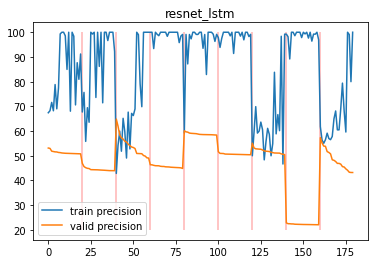

In [27]:
plt.plot(conv1dlstm_train_result,label="train precision")
plt.plot(conv1dlstm_valid_result,label="valid precision")
plt.legend()
plt.title("resnet_lstm")
plt.vlines([20,40,60,80,100,120,140,160], 20, 100, 'r',alpha=0.3)